In [1]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import joblib
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

sns.set()
np.random.seed(7)

In [3]:
df = pd.read_csv('C:/Users/Zhangchensi/bootcamp_Chensi_Zhang/project/data/processed/processed_data.csv')
df = df.set_index(df.columns[0])
df.index.name = None
df

,open,high,low,close,volume,year
2015-01-02,0.050354,0.046686,0.043518,0.045676,0.130251,2015
2015-01-05,0.043057,0.040097,0.038797,0.038268,0.164745,2015
2015-01-06,0.038937,0.037216,0.036898,0.038292,0.169450,2015
2015-01-07,0.040491,0.039035,0.041924,0.041876,0.089477,2015
2015-01-08,0.045269,0.048362,0.046804,0.051834,0.149426,2015
...,...,...,...,...,...,...
2025-08-13,0.332094,0.338466,0.343085,0.343933,0.182155,2025
2025-08-14,0.339121,0.338749,0.344107,0.342610,0.126241,2025
2025-08-15,0.338991,0.336765,0.340420,0.339747,0.139073,2025
2025-08-18,0.333577,0.334026,0.342306,0.338064,0.081290,2025


E:\anaconda\envs\bootcamp_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.4015 - val_loss: 0.4839
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1406 - val_loss: 0.1821
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1011 - val_loss: 0.0635
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0753 - val_loss: 0.0157
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0701 - val_loss: 0.0238
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0548 - val_loss: 0.0089
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0532 - val_loss: 0.0093
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0506 - val_loss: 0.0118
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0442 - val_loss: 0.0302
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0437 - val_loss: 0.0559
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0533 - val_loss: 0.0176
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.

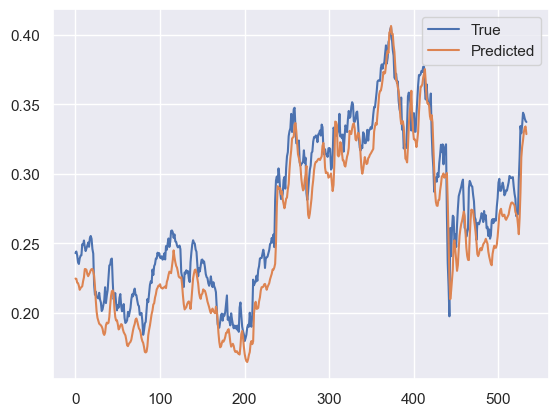

In [4]:
features = ['open', 'high', 'low', 'close', 'volume']
target = 'close'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(df_scaled, columns=features, index=df.index)

time_steps = 3
X, y = [], []
for i in range(time_steps, len(df_scaled)):
    X.append(df_scaled.iloc[i-time_steps:i][features].values)
    y.append(df_scaled.iloc[i][target]) 
X = np.array(X)
y = np.array(y)

split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1, shuffle=False)

y_pred = model.predict(X_test)

close_scaler = StandardScaler()
close_scaler.fit(df[['close']]) 

y_test_orig = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = close_scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
print(f"Test RMSE: {rmse}")

import matplotlib.pyplot as plt
plt.plot(y_test_orig, label='True')
plt.plot(y_pred_orig, label='Predicted')
plt.legend()
plt.show()

In [6]:
joblib.dump(model, 'model/model.pkl')

['model/model.pkl']

In [7]:
loaded_model = joblib.load('model/model.pkl')

In [8]:
%%writefile app.py
from flask import Flask, request, jsonify, render_template_string
import joblib
import matplotlib.pyplot as plt
import io, base64

model = joblib.load('model/model.pkl')
app = Flask(__name__)

def predict(features):
    pred = model.predict([features])[0]
    return pred

@app.route('/')
def home():
    return "<h1>Flask App is Running!</h1><p>Go to <a href='/plot'>/plot</a> for a demo plot.</p>"

@app.route('/predict', methods=['POST'])
def predict_default():
    data = request.get_json()
    features = data.get('features')
    return jsonify({'prediction': float(predict(features))})

@app.route('/predict/<float:input1>')
@app.route('/predict/<float:input1>/<float:input2>')
def predict_path(input1, input2=None):
    if input2 is None:
        features = [input1]
    else:
        features = [input1, input2]
    return jsonify({'prediction': float(predict(features))})

@app.route('/plot')
def plot_page():
    fig, ax = plt.subplots()
    ax.plot([0,1,2,3],[10,20,15,30])
    ax.set_title("Demo Plot")
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    html = f"<html><body><h1>Model Output Plot</h1><img src='data:image/png;base64,{img_base64}'></body></html>"
    return render_template_string(html)

if __name__ == '__main__':
    app.run(debug=False)


Writing app.py


In [13]:
import os

# 先定义 streamlit_code
streamlit_code = """
import streamlit as st
import joblib

# 加载模型
model = joblib.load('model/model.pkl')

st.title("Model Prediction Dashboard")

# 输入特征
input_1 = st.number_input("Feature 1", value=0.0)
input_2 = st.number_input("Feature 2", value=0.0)

if st.button("Predict"):
    pred = model.predict([[input_1, input_2]])
    st.write(f"Prediction: {pred[0]}")
"""

# 保存到 app_streamlit.py
with open("app_streamlit.py", "w", encoding="utf-8") as f:
    f.write(streamlit_code)

print("✅ Streamlit app 已保存到 app_streamlit.py")

# Windows 下启动 Streamlit （会打开一个新的终端窗口）
os.system("start cmd /k streamlit run app_streamlit.py")
print("🚀 Streamlit dashboard 已在新终端启动 (http://localhost:8501)")


✅ Streamlit app 已保存到 app_streamlit.py
🚀 Streamlit dashboard 已在新终端启动 (http://localhost:8501)


In [14]:
from flask import Flask, request, jsonify
import threading
import matplotlib.pyplot as plt
import io, base64, pickle, numpy as np
from typing import Dict, Any, List

app = Flask(__name__)
MODEL_PATH = "model/model.pkl"

# -------- helpers --------
def load_model_obj(path: str) -> Dict[str, Any]:
    with open(path, "rb") as f:
        return pickle.load(f)

def build_row_from_payload(payload: Dict[str, Any], feature_names: List[str]) -> np.ndarray:
    missing = [k for k in feature_names if k not in payload]
    if missing:
        raise ValueError(f"Missing features: {missing}")
    row = []
    for k in feature_names:
        try:
            row.append(float(payload[k]))
        except Exception:
            raise ValueError(f"Feature '{k}' must be numeric.")
    return np.array([row], dtype=float)

# -------- endpoints --------
@app.route("/meta", methods=["GET"])
def meta():
    try:
        obj = load_model_obj(MODEL_PATH)
        m = obj["metrics"]
        return jsonify({"ok": True, "feature_names": m.get("feature_names", []), "metrics": m})
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

@app.route("/predict", methods=["POST"])
def predict():
    try:
        obj = load_model_obj(MODEL_PATH)
        pipe = obj["pipeline"]
        fns = obj["metrics"]["feature_names"]
        if not request.is_json:
            return jsonify({"ok": False, "error": "Request must be application/json"}), 415
        payload = request.get_json(force=True)

        unknown = [k for k in payload.keys() if k not in fns]
        if unknown:
            return jsonify({"ok": False, "error": f"Unknown keys: {unknown}"}), 400

        X = build_row_from_payload(payload, fns)
        yhat = float(pipe.predict(X)[0])
        return jsonify({"ok": True, "prediction": yhat, "features": payload})
    except ValueError as e:
        return jsonify({"ok": False, "error": str(e)}), 400
    except Exception as e:
        return jsonify({"ok": False, "error": f"Unexpected error: {e}"}), 500

@app.route("/predict/", methods=["GET"])
def predict_one(input1: float):
    try:
        obj = load_model_obj(MODEL_PATH)
        pipe = obj["pipeline"]
        fns = obj["metrics"]["feature_names"]
        if len(fns) < 1:
            return jsonify({"ok": False, "error": "Model has no features."}), 500
        payload = {fns[0]: float(input1)}
        for k in fns[1:]:
            payload[k] = 0.0
        X = build_row_from_payload(payload, fns)
        yhat = float(pipe.predict(X)[0])
        return jsonify({"ok": True, "prediction": yhat, "features": payload})
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

@app.route("/predict//", methods=["GET"])
def predict_two(input1: float, input2: float):
    try:
        obj = load_model_obj(MODEL_PATH)
        pipe = obj["pipeline"]
        fns = obj["metrics"]["feature_names"]
        if len(fns) < 2:
            return jsonify({"ok": False, "error": "Model expects at least 2 features."}), 400
        payload = {fns[0]: float(input1), fns[1]: float(input2)}
        for k in fns[2:]:
            payload[k] = 0.0
        X = build_row_from_payload(payload, fns)
        yhat = float(pipe.predict(X)[0])
        return jsonify({"ok": True, "prediction": yhat, "features": payload})
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

@app.route("/plot", methods=["GET"])
def plot():
    try:
        xs = np.linspace(-3, 3, 200)
        ys = xs ** 2
        fig, ax = plt.subplots()
        ax.plot(xs, ys, label="y=x^2")
        ax.axhline(0, linestyle="--", linewidth=1)
        ax.set_title("Sample Plot")
        ax.legend()
        buf = io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        img_b64 = base64.b64encode(buf.read()).decode("utf-8")
        html = f''
        return html
    except Exception as e:
        return jsonify({"ok": False, "error": str(e)}), 500

def run_flask():
    app.run(port=5000, debug=False)

# Launch Flask in a separate thread (so notebook remains responsive)
threading.Thread(target=run_flask, daemon=True).start()
print("Flask server started on http://127.0.0.1:5000")


Flask server started on http://127.0.0.1:5000
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
